See for examples https://github.com/cduck/drawSvg

Great series on SVG coordinates https://www.sarasoueidan.com/blog/svg-coordinate-systems/

In [26]:
import drawSvg as draw
import numpy as np
from matplotlib.cm import tab20c
from matplotlib.colors import rgb2hex
from itertools import chain
from pathlib import Path
from typing import List, Collection, Callable, Tuple, Set
import networkx as nx
import pandas as pd

In [27]:
PALETTE = [rgb2hex(tab20c(i)) for i in range(tab20c.N)]
DELIM = ","
PAIR_IDX = ("sample1", "sample2")

In [28]:
class AsymmetrixMatrixError(Exception):
    pass

def load_matrix(fpath, delim: str = DELIM, name: str = "") -> pd.Series:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    sorted_matrix = np.array(matrix)[idx]
    n_samples = len(sorted_names)
    diagonal_is_zero = all(sorted_matrix[i, i] == 0 for i in range(n_samples))
    if not diagonal_is_zero:
        raise AsymmetrixMatrixError("Distance matrix diagonal is not all zero")

    matrix_is_symmetric = np.allclose(sorted_matrix, sorted_matrix.T)
    if not matrix_is_symmetric:
        raise AsymmetrixMatrixError("Distance matrix is not symmetric")

    mx = pd.DataFrame(sorted_matrix, columns=sorted_names, index=sorted_names)
    # remove the lower triangle of the matrix and the middle diagonal
    mx = mx.where(np.triu(np.ones(mx.shape), k=1).astype(bool))
    mx = mx.stack().rename(name).astype(int)
    mx = mx.rename_axis(PAIR_IDX)

    return mx


def dist_matrix_to_graph(mx: pd.Series, threshold: int, include_singletons: bool=False) -> nx.Graph:
    edges = [(s1, s2, dist) for (s1, s2), dist in mx.iteritems() if dist <= threshold]
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)
    if include_singletons:
        samples = set()
        for u in chain.from_iterable(mx.index):
            if u not in samples:
                graph.add_node(u)
                samples.add(u)
            if u not in samples:
                graph.add_node(v)
                samples.add(v)
    return graph

In [46]:
W = 800
H = 800
ITS = [0, 2, 5, 12]  # illumina distance thresholds
NTS = [0, 3, 5, 11]  # nanopore distance thresholds
L = len(ITS)
mtx = load_matrix("../eda/compass.matrix.csv", name="compass")

In [54]:
# calculate the most number of clusters at any threshold
max_n_clusters = 0
for t in ITS:
    G = dist_matrix_to_graph(mtx, threshold=t, include_singletons=False)
    n = len(list(nx.connected_components(G)))
    if n > max_n_clusters:
        max_n_clusters = n

In [63]:
help(draw.Line)

Help on class Line in module drawSvg.elements:

class Line(Lines)
 |  Line(sx, sy, ex, ey, **kwargs)
 |  
 |  A line
 |  
 |  Additional keyword arguments are output as additional properties to the
 |  SVG node e.g. fill="red", stroke="#ff4477", stroke_width=2.
 |  
 |  Method resolution order:
 |      Line
 |      Lines
 |      Path
 |      DrawingBasicElement
 |      DrawingElement
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, sx, sy, ex, ey, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from Path:
 |  
 |  A(self, rx, ry, rot, largeArc, sweep, ex, ey)
 |  
 |  C(self, cx1, cy1, cx2, cy2, ex, ey)
 |  
 |  H(self, x)
 |  
 |  L(self, x, y)
 |  
 |  M(self, x, y)
 |  
 |  Q(self, cx, cy, ex, ey)
 |  
 |  S(self, cx2, cy2, ex, ey)
 |  
 |  T(self, ex, ey)
 |  
 |  V(self, y)
 |  
 |  Z(self)
 |  
 |  a(self, rx, ry, rot

In [87]:
# note the origin here is actually the bottom left, not top left
canvas = draw.Drawing(width=W, height=H, origin=(0, 0), displayInline=False)

# create the boundaries for the different thresholds
for y in np.arange(H/L, H, H/L):
    start = (0, y)
    end = (W, y)
    canvas.append(draw.Line(*start, *end, stroke="black", stroke_dasharray="5 5 4"))
    
for i, t in enumerate(ITS, start=1):
    x = 0
    y = H - (((H/L)*i - (H/L/2)))
    txt = draw.Text(f"{t}", fontSize=12, x=x, y=y)
    canvas.append(txt)
    
black = "#2e3440"
# u = draw.Circle(cx=(W*0.1), cy=H-(H*0.05), r=15, fill=PALETTE[0], stroke=black, stroke_width=2)
# canvas.append(u)
# v = draw.Circle(cx=(W*0.1), cy=H-(H*0.15), r=15, fill=PALETTE[0], stroke=black, stroke_width=2)
# canvas.append(v)
# p = draw.Path()

# draw guide lines for the maximum number of clusters
cluster_x_coords = np.linspace(0, W, num=max_n_clusters+1, endpoint=False)[1:]
for i, x in enumerate(cluster_x_coords):
    sx = x
    sy = H
    ex = x
    ey = 0
    canvas.append(draw.Line(sx, sy, ex, ey, stroke=PALETTE[i]))

    
ypad = 10
xpos = dict()
CID = 0
for i, t in enumerate(ITS, start=1):
    y = (H - (((H/L)*i - (H/L/2)))) - ypad
    G = dist_matrix_to_graph(mtx, threshold=t, include_singletons=False)
    clusters = list(nx.connected_components(G))
    for j, c in enumerate(clusters):
        cy = y
        existing_ids = set()
        for v in c:
            if v in xpos:
                existing_ids.add(xpos[v])
        
        if not existing_ids:
            cid = CID
            CID += 1
        else:
            cid = sorted(existing_ids)[0]
        
        for k, v in enumerate(c):
            if v not in xpos:
                xpos[v] = cid
                
            x = cluster_x_coords[xpos[v]]
            cy += k
            draw.Text(v, fontSize=12, x=x, y=cy)
        

canvas

IndexError: index 19 is out of bounds for axis 0 with size 19

In [88]:
xpos

{'R20260': 0,
 'R20574': 0,
 'R30078': 1,
 'R27657': 1,
 'R28012': 1,
 'R30234': 2,
 'R31095': 2,
 'mada_2-25': 3,
 'mada_1-25': 3,
 'mada_2-46': 4,
 'mada_1-46': 4,
 'mada_152': 5,
 'mada_132': 5,
 '17_616026': 6,
 '17_616156': 6,
 'R18043': 7,
 'R22601': 7,
 'R18040': 7,
 'R20983': 8,
 'R21770': 8,
 'mada_2-53': 9,
 'mada_1-53': 9,
 'R27937': 7,
 'R27725': 7,
 'R29816': 10,
 'R36431': 10,
 'mada_1-7': 11,
 'mada_1-3': 11,
 'R26791': 7,
 'R28182': 7,
 'R20896': 12,
 'R30396': 12,
 'R28980': 13,
 'R23146': 13,
 'R29598': 14,
 'R24100': 14,
 'R24120': 1,
 'mada_115': 15,
 'mada_125': 15,
 'mada_1-8': 15,
 'mada_1-28': 15,
 'mada_1-11': 15,
 'mada_142': 15,
 'mada_1-44': 16,
 'mada_1-40': 16,
 'mada_2-31': 17,
 'mada_1-41': 17,
 'mada_103': 18,
 'mada_110': 18,
 'mada_112': 18,
 'mada_126': 19}

In [90]:
len(cluster_x_coords)

19

In [29]:
help(draw.Circle)

Help on class Circle in module drawSvg.elements:

class Circle(DrawingBasicElement)
 |  Circle(cx, cy, r, **kwargs)
 |  
 |  A circle
 |  
 |  Additional keyword arguments are output as additional properties to the
 |  SVG node e.g. fill="red", stroke="#ff4477", stroke_width=2.
 |  
 |  Method resolution order:
 |      Circle
 |      DrawingBasicElement
 |      DrawingElement
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, cx, cy, r, **kwargs)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  TAG_NAME = 'circle'
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from DrawingBasicElement:
 |  
 |  __eq__(self, other)
 |      Return self==value.
 |  
 |  allChildren(self)
 |      Returns self.children and self.orderedChildren as a single list.
 |  
 |  app

In [18]:
help(enumerate)

Help on class enumerate in module builtins:

class enumerate(object)
 |  enumerate(iterable, start=0)
 |  
 |  Return an enumerate object.
 |  
 |    iterable
 |      an object supporting iteration
 |  
 |  The enumerate object yields pairs containing a count (from start, which
 |  defaults to zero) and a value yielded by the iterable argument.
 |  
 |  enumerate is useful for obtaining an indexed list:
 |      (0, seq[0]), (1, seq[1]), (2, seq[2]), ...
 |  
 |  Methods defined here:
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __iter__(self, /)
 |      Implement iter(self).
 |  
 |  __next__(self, /)
 |      Implement next(self).
 |  
 |  __reduce__(...)
 |      Return state information for pickling.
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.



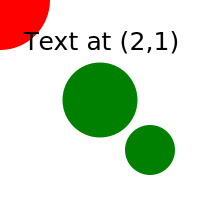

In [72]:
d = draw.Drawing(4,4, origin=(0,0))

g = draw.Group(transform='scale(1,-1) translate(0,4)')
g.append(draw.Circle(0,0,1, fill='red'))
g.append(draw.Circle(2,2,0.75, fill='green'))
g.append(draw.Circle(3,3,0.5, fill='green'))
g.append(draw.Text('Text at (2,1)',0.5, 0,0, text_anchor='middle',
                   transform='scale(1,-1) translate(2,1)'))
d.append(g)

d.setRenderSize(h=200)
d